In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import tensorflow as tf

In [66]:
def Load_WISDM_dataset(file_path):
    cleaned_rows = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            # Line ends with ;, so we may get it as part of the last value
            if len(parts) == 6 or len(parts) == 7:  # Acceptable lines
                try:
                    user = int(parts[0])
                    activity = parts[1]
                    timestamp = int(parts[2])
                    x = float(parts[3])
                    y = float(parts[4])
                    z = float(parts[5].replace(';', ''))  # Clean the ;
                    cleaned_rows.append([user, activity, timestamp, x, y, z])
                except ValueError:
                    continue  # skip malformed lines

    columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
    df = pd.DataFrame(cleaned_rows, columns=columns)
    return df

In [67]:
df = Load_WISDM_dataset('datasets/WISDM/WISDM_raw.txt')

In [68]:
df = df.iloc[:500000].copy()
print(df['activity'].value_counts())
print(df.shape)
df.head()

activity
Walking       208519
Jogging       159792
Upstairs       53856
Downstairs     49607
Sitting        15561
Standing       12665
Name: count, dtype: int64
(500000, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [69]:
def extract_features_from_window(window):
    features = []

    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features += [
            data.mean(),
            data.std(),
            data.min(),
            data.max(),
            data.median(),
            np.sqrt(np.sum(data**2)),  # Energy
        ]
    return features


In [70]:
def create_feature_dataset(df, window_size=50, step_size=25):
    X_features = []
    y_labels = []

    for user_id in df['user'].unique():
        user_data = df[df['user'] == user_id]

        for i in range(0, len(user_data) - window_size, step_size):
            window = user_data.iloc[i:i+window_size]
            if len(window['activity'].unique()) == 1:
                features = extract_features_from_window(window)
                X_features.append(features)
                y_labels.append(window['activity'].iloc[0])

    return np.array(X_features), np.array(y_labels)


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [72]:

# Generate features
X, y = create_feature_dataset(df, window_size=50, step_size=25)
print(X.shape, y.shape)


(19631, 18) (19631,)


In [73]:
from sklearn.preprocessing import LabelEncoder

# Encode activity labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [74]:
# Train/Test split with encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [76]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM
svm_rbf = SVC(kernel='rbf', C=1)
svm_rbf.fit(X_train, y_train)

# Evaluate
y_pred = svm_rbf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       407
           1       0.99      0.99      0.99      1279
           2       0.99      1.00      1.00       106
           3       1.00      1.00      1.00        95
           4       0.82      0.67      0.74       428
           5       0.90      0.99      0.94      1612

    accuracy                           0.92      3927
   macro avg       0.93      0.89      0.91      3927
weighted avg       0.92      0.92      0.92      3927



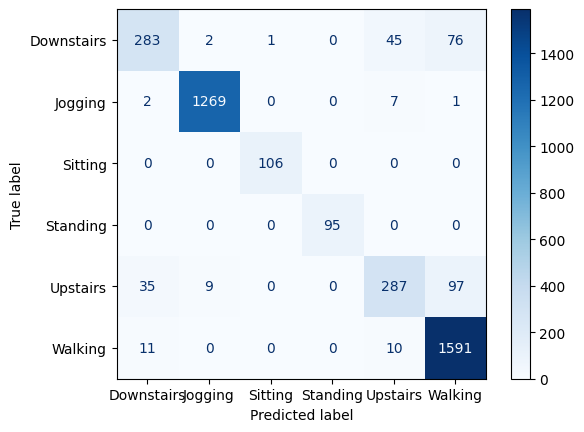

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')

              precision    recall  f1-score   support

           0       0.86      0.51      0.64       407
           1       0.99      0.98      0.99      1279
           2       0.99      1.00      1.00       106
           3       1.00      1.00      1.00        95
           4       0.86      0.55      0.67       428
           5       0.83      1.00      0.90      1612

    accuracy                           0.89      3927
   macro avg       0.92      0.84      0.87      3927
weighted avg       0.90      0.89      0.88      3927



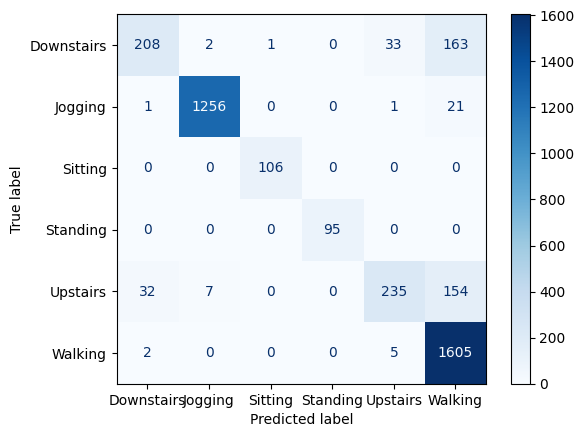

In [78]:
svm_poly = SVC(kernel='poly', C=1)
svm_poly.fit(X_train, y_train)

# Evaluate
y_pred = svm_poly.predict(X_test)
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')

In [79]:
# 1D CNN

In [80]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_cat = to_categorical(y_encoded)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Reshape for Conv1D input (add time_steps dimension = 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Ensure shape is (samples, time_steps, features)
print("X shape:", X_train.shape)  # e.g., (800, 20, 3)
print("y shape:", y_train.shape)  # e.g., (800, 4)

X shape: (15704, 18, 1)
y shape: (15704, 6)


In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.5))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(y_train.shape[1], activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()


/mnt/c/Users/Aayush/Desktop/Projects/SVMvsDL/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 16, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,162 (203.76 KB)

 Trainable params: 52,162 (203.76 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history = model_cnn.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6342 - loss: 1.4331 - val_accuracy: 0.8415 - val_loss: 0.4951
Epoch 2/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8036 - loss: 0.5431 - val_accuracy: 0.8351 - val_loss: 0.4617
Epoch 3/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8320 - loss: 0.4724 - val_accuracy: 0.8663 - val_loss: 0.3662
Epoch 4/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8486 - loss: 0.4280 - val_accuracy: 0.8561 - val_loss: 0.3836
Epoch 5/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8566 - loss: 0.4017 - val_accuracy: 0.8765 - val_loss: 0.3709
Epoch 6/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8596 - loss: 0.3905 - val_accuracy: 0.8886 - val_loss: 0.3069
Epoch 7/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8690 - loss: 0.3702 - val_accuracy: 0.8956 - val_loss: 0.3016
Epoch 8/15
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8693 - loss: 0.3576 - val_accuracy: 0

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9077 - loss: 0.2333
Test Accuracy: 0.91
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       407
           1       0.98      0.99      0.99      1279
           2       1.00      1.00      1.00       106
           3       1.00      0.99      0.99        95
           4       0.80      0.61      0.69       428
           5       0.87      0.99      0.93      1612

    accuracy                           0.91      3927
   macro avg       0.91      0.86      0.88      3927
weighted avg       0.90      0.91      0.90      3927



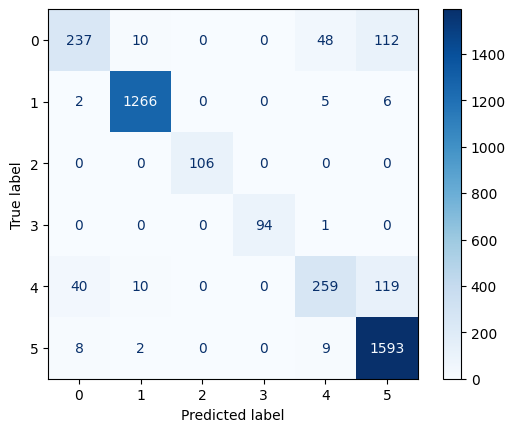

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate
loss, accuracy = model_cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict
y_pred = model_cnn.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred_labels))

# Optional: Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()


In [84]:
# GRU

In [105]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Prepare Data ---

# Suppose: X, y are your loaded data.
# X shape: (num_samples, num_features)
# y labels: strings like 'Jogging', 'Sitting', etc.

# Encode labels if still strings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts 'Jogging', etc. to 0,1,2,..

# One-hot encode labels
y_cat = to_categorical(y_encoded)

# Reshape X if needed
# For GRU: we need (samples, timesteps, features)
# Let's assume we make sequences of 50 timesteps
timesteps = 50
features = X.shape[1]

# Create sequences

def create_userwise_sequences(X, y, user_ids, timesteps, stride=1):
    Xs, ys = [], []
    unique_users = np.unique(user_ids)
    
    for user in unique_users:
        user_indices = np.where(user_ids == user)[0]
        user_X = X[user_indices]
        user_y = y[user_indices]
        
        # Now apply sliding window inside this user's data
        for i in range(0, len(user_X) - timesteps, stride):
            Xs.append(user_X[i:(i + timesteps)])
            ys.append(user_y[i + timesteps])
    
    return np.array(Xs), np.array(ys)
    
X_seq, y_seq = create_userwise_sequences(X, y_cat, user_ids, timesteps=50, stride=1)



# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# --- Step 2: Build Model ---

num_classes = y_cat.shape[1]

model = Sequential([
    GRU(64, input_shape=(timesteps, features)),
    Dense(num_classes, activation='softmax')
])

# --- Step 3: Compile ---

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Step 4: Train ---

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

# --- Step 5: Evaluate and Confusion Matrix ---

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=le.classes_))


NameError: name 'user_ids' is not defined